In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Model, Layer, layers, optimizers, losses, metrics, regularizers, callbacks

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [3]:
from config import Config
from utils.data_loader import DataLoader

In [4]:
train_df = DataLoader().load_train_data()

In [5]:
train_df

,user_id,item_id,rating
0,716,836,4
1,620,422,1
2,547,289,3
3,758,385,4
4,627,197,5
...,...,...,...
79995,336,628,3
79996,749,637,1
79997,758,313,4
79998,380,139,1


In [6]:
val_df = DataLoader().load_val_data()

In [7]:
val_df

,user_id,item_id,rating
0,655,911,2
1,200,88,4
2,763,607,4
3,500,714,2
4,690,163,3
...,...,...,...
19995,932,38,2
19996,154,874,3
19997,527,425,4
19998,464,333,4


In [8]:
x_train, x_test, y_train, y_test = train_df[['user_id', 'item_id']].values, val_df[['user_id', 'item_id']].values, train_df['rating'].values, val_df['rating'].values

In [9]:
x_train.shape

(80000, 2)

In [10]:
class DeepMF(keras.Model):
    
    def __init__(
        self,
        latent_dim:int = 5, 
        num_users:int = Config.Vars.NUM_USERS,
        num_items:int = Config.Vars.NUM_ITEMS,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_users = num_users
        self.num_items = num_items
        self.user_embedding = layers.Embedding(self.num_users + 1, self.latent_dim, name='user_embedding')
        self.user_flatten = layers.Flatten(name='user_flatten')
        self.item_embedding = layers.Embedding(self.num_items + 1, self.latent_dim, name='item_embedding')
        self.item_flatten = layers.Flatten(name='item_flatten')
        self.dot = layers.Dot(axes=1, name='dot')
    
    def call(self, inputs):
        user_id, item_id = inputs[0], inputs[1]
        user_emb = self.user_embedding(user_id)
        user_emb = self.user_flatten(user_emb)
        item_emb = self.item_embedding(item_id)
        item_emb = self.item_flatten(item_emb)
        rating_vec = self.dot([user_emb, item_emb])
        return rating_vec
    
    
    def summary(self):
        x = layers.Input(shape=[2])
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()
    
    def build_graph(self):
        x = layers.Input(shape=[2])
        return Model(inputs=[x], outputs=self.call(x))

In [11]:
deepmf = DeepMF()
deepmf.compile(
    optimizer=optimizers.Adam(),
    loss=losses.MeanSquaredError(),
    metrics=[metrics.MeanSquaredError()]
)

2024-05-18 22:25:39.412642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 22:25:39.454034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 22:25:39.454344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
deepmf.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_test[:, 0], x_test[:, 1]], y_test),
    epochs=10,
    batch_size=32,
    validation_freq=3
)

Epoch 1/10


I0000 00:00:1716051341.298249   26045 service.cc:145] XLA service 0x748bec005810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716051341.298277   26045 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-18 22:25:41.356263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-18 22:25:41.467429: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 142/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 13.7068 - mean_squared_error: 13.7068  

I0000 00:00:1716051341.729171   26045 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 13.2641 - mean_squared_error: 13.2641
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - loss: 4.5292 - mean_squared_error: 4.5292
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6653 - mean_squared_error: 1.6653 - val_loss: 1.2761 - val_mean_squared_error: 1.2761
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1656 - mean_squared_error: 1.1656
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step - loss: 0.9902 - mean_squared_error: 0.9902
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step - loss: 0.9277 - mean_squared_error: 0.9277 - val_loss: 0.9472 - val_mean_squared_error: 0.9472
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 597us/step - loss: 0.8995 - mean_squared_error: 0.8995
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 616us/step - loss: 0.8816 - mean_squared_error: 0.8816
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 745us/step - loss: 0.8728 - mean_squared_error: 0.8728 - val_loss:

In [15]:
deepmf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (2)               │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (2)               │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (2, 5)            │      4,720 │ get_item[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (2, 5)            │      8,415 │ get_item_1[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (2, 5)            │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_flatten        │ (2, 5)            │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (2, 1)            │          0 │ user_flatten[0][… │
│                     │                   │            │ item_flatten[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,135 (51.31 KB)

 Trainable params: 13,135 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
deepmf.predict([x_test[:, 0], x_test[:, 1]])

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


array([[2.0714521],
       [4.0709133],
       [4.0680127],
       ...,
       [3.7946146],
       [3.9072058],
       [3.4799936]], dtype=float32)

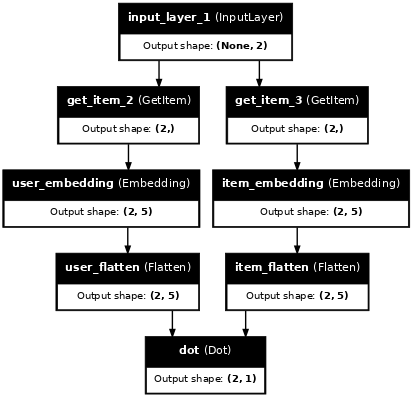

In [17]:
keras.utils.plot_model(
    deepmf.build_graph(),
    show_shapes=True,
    show_layer_names=True,
    dpi=50
)

In [ ]:
class GAN(Model):
    
    def __init__(
        self,
        generator: Model,
        discrimator: Model,
        latent_dim: int = 100,
        **kwargs
    ):
        super(GAN, self).__init__(**kwargs)
        self.generator = generator
        self.discrimator = discrimator
        self.latent_dim = latent_dim
    
    def call(self, inputs, training=False):
        noise_vec, input_tensor = inputs
        
        gen_tensor = self.generator(noise_vec, training=True)
        
        real_output = self.discrimator(input_tensor, training=True)
        gen_output = self.discrimator(gen_tensor, training=True)
        
        return gen_tensor, real_output, gen_output
    
    def compile(
        self,
        gen_optimizer: keras.Optimizer,
        disc_optimizer: keras.Optimizer,
        **kwargs
    ):
        super(GAN, self).compile(**kwargs)
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
    
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        _, real_output, gen_output = y_pred
        
        gen_loss = losses.binary_crossentropy(tf.ones_like(gen_output), gen_output)
        disc_loss = losses.binary_crossentropy(tf.ones_like(real_output), real_output) + losses.binary_crossentropy(tf.zeros_like(gen_output), gen_output)
        
        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss
        }
    
    def train_step(self, inputs):
        
        noise_vec = tf.random.normal((tf.shape(inputs)[0], self.latent_dim))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_tensor, real_output, gen_output = self.call(inputs=(noise_vec, inputs), training=True)
            loss = self.compute_loss(y=[inputs, real_output, gen_output])
        
        gen_grads = gen_tape.gradient(loss['gen_loss'], self.generator.trainable_weights)
        disc_grads = disc_tape.gradient(loss['disc_loss'], self.discrimator.trainable_weights)
        
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrimator.trainable_weights))
        
        return {
            'gen_loss': loss['gen_loss'],
            'disc_loss': loss['disc_loss']
        }
    
    def predict(self, x):
        return self.generator(x)
    
    def summary(self):
        if isinstance(self.discrimator, keras.src.models.Functional):
            input_shape = self.discrimator.layers[1].input.shape[1:]
        else:
            input_shape = self.discrimator.layers[0].input.shape[1:]
        
        input_tensor = layers.Input(shape=input_shape)
        noise_vec = layers.Input(shape=(self.latent_dim,))
        
        model = Model(inputs=[noise_vec, input_tensor], outputs=self.call([noise_vec, input_tensor]))
                
        return model.summary()
    
    def build_graph(self):
        if isinstance(self.discrimator, keras.src.models.Functional):
            input_shape = self.discrimator.layers[1].input.shape[1:]
        else:
            input_shape = self.discrimator.layers[0].input.shape[1:]
        
        input_tensor = layers.Input(shape=input_shape)
        noise_vec = layers.Input(shape=(self.latent_dim,))
        
        return Model(inputs=[noise_vec, input_tensor], outputs=self.call([noise_vec, input_tensor]))

In [23]:
def build_generator():
        latent_dim = 10
        model = keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(units=latent_dim),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(momentum=0.8),
            layers.Dense(20),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(rate=0.2),
            layers.Dense(units=latent_dim * 2 + 1),
        ])
        
        return model

In [24]:
def build_discriminator():
        latent_dim = 10
        model = keras.Sequential([
            layers.Input(shape=(latent_dim * 2 + 1, )),
            layers.Dense(units=latent_dim * 2 + 1),
            layers.LeakyReLU(alpha=0.2),
            layers.Dense(units=1),
            layers.Activation('sigmoid')
        ])
        
        return model